In [60]:
%reload_ext autoreload
%autoreload 2

import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
from pytz import UTC, timezone
import seaborn as sns
from datetime import datetime, timedelta
import concurrent.futures

from watttime import WattTimeForecast, WattTimeHistorical, RecalculatingWattTimeOptimizer, RecalculatingWattTimeOptimizerWithContiguity, WattTimeOptimizer

import data.s3 as s3u
import evaluation.eval_framework as efu
from plotnine import *

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()

In [3]:
tz = "America/Chicago"

In [64]:
region = "PJM_CHICAGO"
start_time = datetime(2023, 1, 21, 2, 6)
start_time = UTC.localize(start_time)
end_time = start_time + timedelta(hours = 12)
usage_time = 100
usage_power = 2
optimization_method="simple"
requery_interval_minutes = 60

In [65]:
forecast_generator = WattTimeForecast(username, password)

moer_data_list = []

new_start_time = start_time

while new_start_time < end_time:
            
    new_data = forecast_generator.get_historical_forecast_pandas(
                start=new_start_time - timedelta(minutes=5), 
                end=new_start_time,
                region=region,
                signal_type="co2_moer",
                horizon_hours=72,
            )
    new_data["point_time"] = pd.to_datetime(new_data["point_time"])
    moer_data_list.append(new_data)
            
    new_start_time = new_start_time + timedelta(minutes = requery_interval_minutes)

In [71]:
print("Using auto mode, but constrained to a single contiguous interval")
wt_opt = WattTimeOptimizer(username, password)
dp_usage_plan_5 = wt_opt.get_optimal_usage_plan(
    region=region,
    usage_window_start=start_time,
    usage_window_end=end_time,
    usage_time_required_minutes=100,
    usage_power_kw=usage_power,
    moer_data_override=moer_data_list[0],
    charge_per_interval=[25, 25, 25, 25],
    optimization_method="sophisticated",
)
print(dp_usage_plan_5["usage"].tolist())
print(dp_usage_plan_5.sum())

Using auto mode, but constrained to a single contiguous interval
== Fixed contiguous fit! ==
Cumulative charge [0, 5, 10, 15, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
pred_moer            170344.000000
usage                   100.000000
emissions_co2e_lb         3.847600
energy_usage_mwh          0.003333
dtype: fl

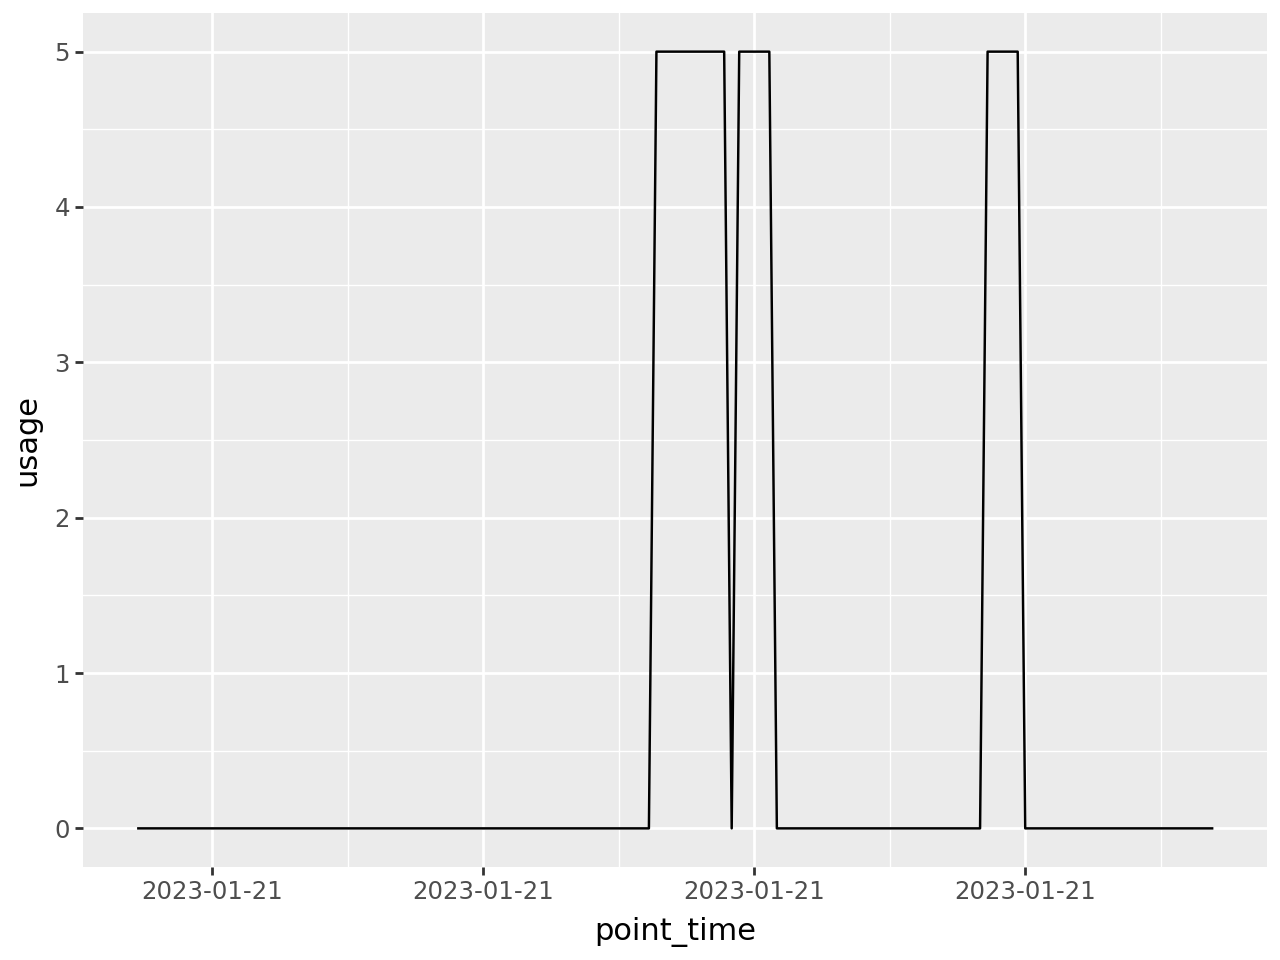

In [72]:
(ggplot(dp_usage_plan_5.reset_index(), aes(x = "point_time", y = "usage")) + geom_line())

In [73]:
wt_opt_recalc_cont = RecalculatingWattTimeOptimizerWithContiguity(username,
                                                                  password,
                                                                  region,
                                                                  usage_time,
                                                                  usage_power,
                                                                  optimization_method="auto",
                                                                  charge_per_interval=[25, 25, 25, 25])

new_start_time = start_time

for curr_fcst_data in moer_data_list:
    new_start_time = pd.to_datetime(curr_fcst_data["point_time"]).min()
    print(f"MOER start time: {new_start_time}")
    wt_opt_recalc_cont.get_new_schedule(new_start_time=new_start_time, new_end_time=end_time, curr_fcst_data=curr_fcst_data)

MOER start time: 2023-01-21 02:05:00+00:00
== Fixed contiguous fit! ==
Cumulative charge [0, 5, 10, 15, 20]
MOER start time: 2023-01-21 03:05:00+00:00
starting charge indicator: 0
starting completed segments: 0
== Fixed contiguous fit! ==
Cumulative charge [0, 5, 10, 15, 20]
MOER start time: 2023-01-21 04:05:00+00:00
starting charge indicator: 0
starting completed segments: 0
== Fixed contiguous fit! ==
Cumulative charge [0, 5, 10, 15, 20]
MOER start time: 2023-01-21 05:05:00+00:00
starting charge indicator: 0
starting completed segments: 0
== Fixed contiguous fit! ==
Cumulative charge [0, 5, 10, 15, 20]
MOER start time: 2023-01-21 06:05:00+00:00
starting charge indicator: 0
starting completed segments: 0
== Fixed contiguous fit! ==
Cumulative charge [0, 5, 10, 15, 20]
MOER start time: 2023-01-21 07:05:00+00:00
starting charge indicator: 0
starting completed segments: 0
== Fixed contiguous fit! ==
Cumulative charge [0, 5, 10, 15, 20]
MOER start time: 2023-01-21 08:05:00+00:00
starting 

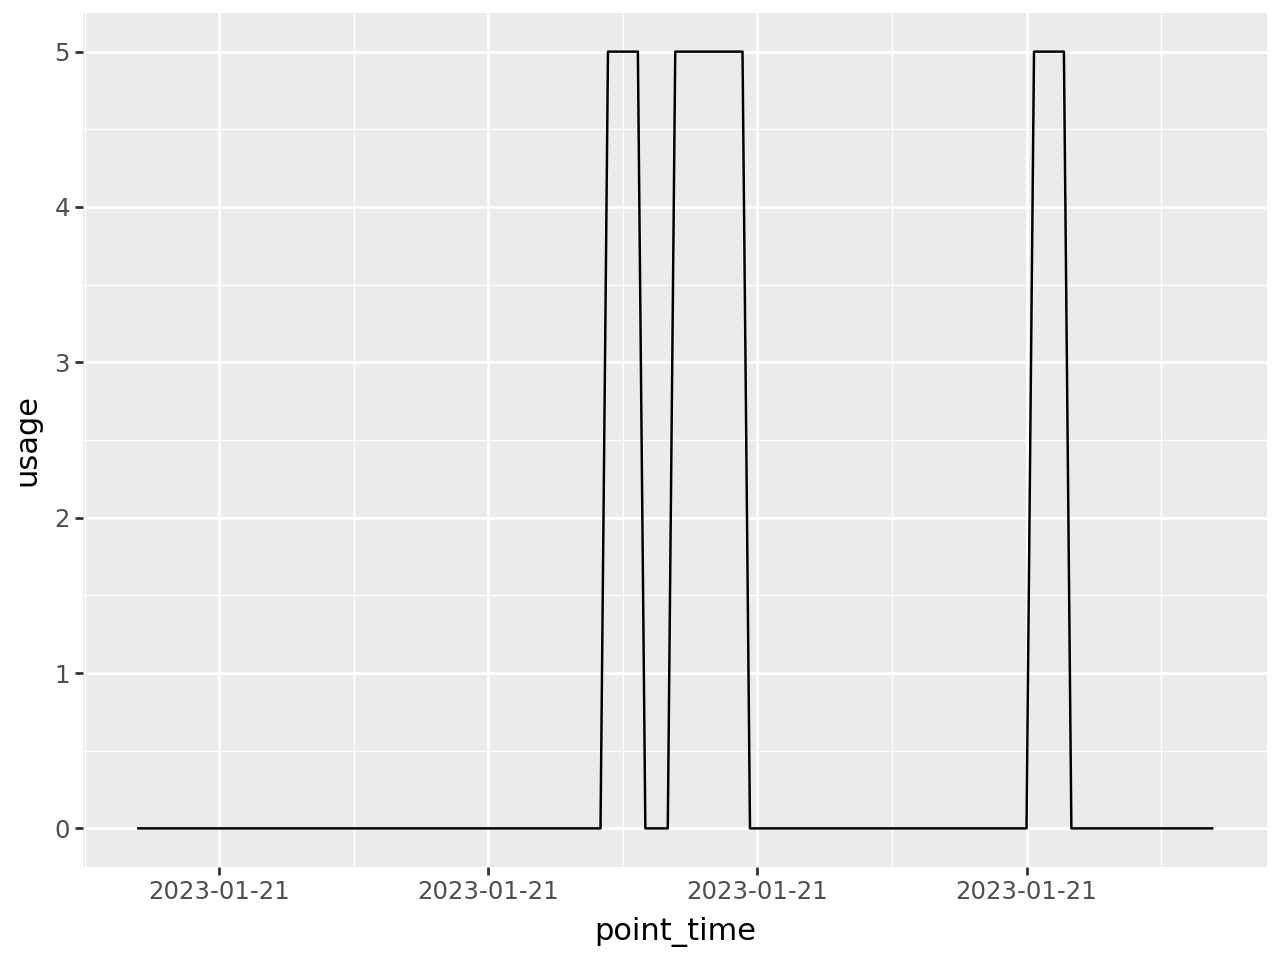

In [74]:
(ggplot(wt_opt_recalc_cont.get_combined_schedule().reset_index(), aes(x = "point_time", y = "usage")) + geom_line())

In [63]:
wt_opt_recalc_cont.get_combined_schedule().reset_index().usage.sum()

np.float64(100.0)

In [12]:
from itertools import accumulate
import bisect

bisect.bisect_right(list(accumulate([25, 75, 100])), 110)

2

In [15]:
list(accumulate([(0, 100), (0, 100)]))

[(0, 100), (0, 100, 0, 100)]

In [37]:
[25, 25, 25, 25][1:]

[25, 25, 25]